In [24]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed, Embedding, GlobalAveragePooling1D, Flatten, SimpleRNN, GRU, Dropout, LSTM, Bidirectional, Lambda, Add
from tensorflow.keras.backend import sum
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import os
import re

# Exercício 1
*Objetivo: explicar as etapas de transformações que são realizadas sobre os dados num processo de classificação com rede neural*

O código abaixo mostra todas as etapas de um processo de treinamento de uma rede neural para análise de sentimentos.

1. Encontre todas as manipulações e transformações que são feitas com o dataset
1. Justifique a relevância de cada uma dessas manipulações, ou, em outras palavras: o que aconteceria se retirássemos cada uma das manipulações?

In [2]:
df = pd.read_csv('./datasets/IMDB Dataset.csv')
reviews = list(df['review'])

labels = np.array([list(df['sentiment'])]).T
ohe = OneHotEncoder()
y = ohe.fit_transform(labels).toarray()

In [3]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(sequences,maxlen=200)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2)

2022-05-24 16:40:06.196550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 16:40:06.209664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 16:40:06.210880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 16:40:06.212600: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

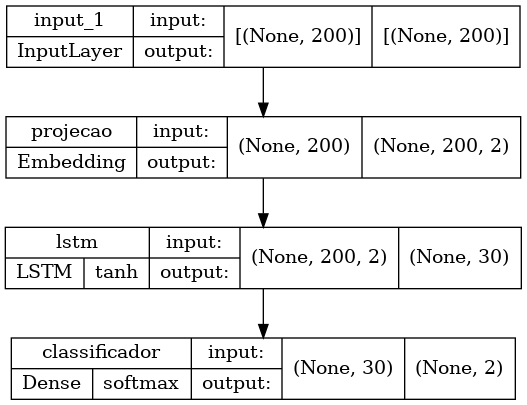

In [6]:
def rede_neural_com_RNN(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x = LSTM(30)(x)
  y = Dense(2, activation='softmax', name='classificador')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_com_RNN(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=es)

Epoch 1/50


2022-05-24 16:40:11.037816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


1000/1000 [==============================] - 34s 30ms/step - loss: 0.1525 - val_loss: 0.1213
Epoch 2/50
1000/1000 [==============================] - 28s 28ms/step - loss: 0.1054 - val_loss: 0.1030
Epoch 3/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1022 - val_loss: 0.1044
Epoch 4/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.0981 - val_loss: 0.1078
Epoch 5/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.0978 - val_loss: 0.1045
Epoch 6/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.0968 - val_loss: 0.1034
Epoch 7/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.0970 - val_loss: 0.1074
Epoch 8/50
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0963 - val_loss: 0.1005
Epoch 9/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.0952 - val_loss: 0.0998
Epoch 10/50
1000/1000 [==============================] - 29s 29ms/step - lo

In [8]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.88      0.85      0.86      5053
    positive       0.85      0.88      0.86      4947

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



# Exercício 2
*Objetivo: explicar o conceito de atenção*

Em um processo de classificação de texto, é evidente que nem todas as palavras têm a mesma relevância.

1. Na frase: "este filme sobre o lindo mar é terrível", quais palavras são (a) absolutamente irrelevantes, (b) um pouco relevantes e (c) mais relevantes?
1. Na frase: "este filme sobre o terrível mar é lindo", quais palavras são (a) absolutamente irrelevantes, (b) um pouco relevantes e (c) mais relevantes?
1. Ao decidir sobre a relevância de palavras, a ordem de palavras importa?
1. A relevância de uma palavra depende das palavras que a antecedem?
1. A relevância de uma palavra depende das palavras que a sucedem?

# Exercício 3
*Objetivo: entender a implementação de um processo de atenção*

Uma das maneiras de aplicar atenção a uma sequência é multiplicar cada elemento da sequência por um número real, que é alto se aquele elemento recebe mais atenção, e baixo se o elemento não recebe atenção. Após, o resultado pode ser somado. Em outras palavras, *aplicar atenção* significa fazer uma espécie de *média ponderada* das entradas.

Na função abaixo, como esse conceito é aplicado?

In [9]:
def aplicar_atencao(par):
  estados, atencao = par[0], par[1]
  atencao_aplicada = estados * atencao
  contexto = sum(atencao_aplicada, axis=1)
  return contexto

# Exercício 4
*Objetivo: explicar como a atenção pode ser calculada em uma rede neural*

Analisando a rede neural abaixo, encontre:
1. Quais blocos estão presentes nela, mas não estavam no classificador que fizemos no começo desta aula?
1. Como o valor da *atenção* é calculado?
1. Como a atenção é aplicada?

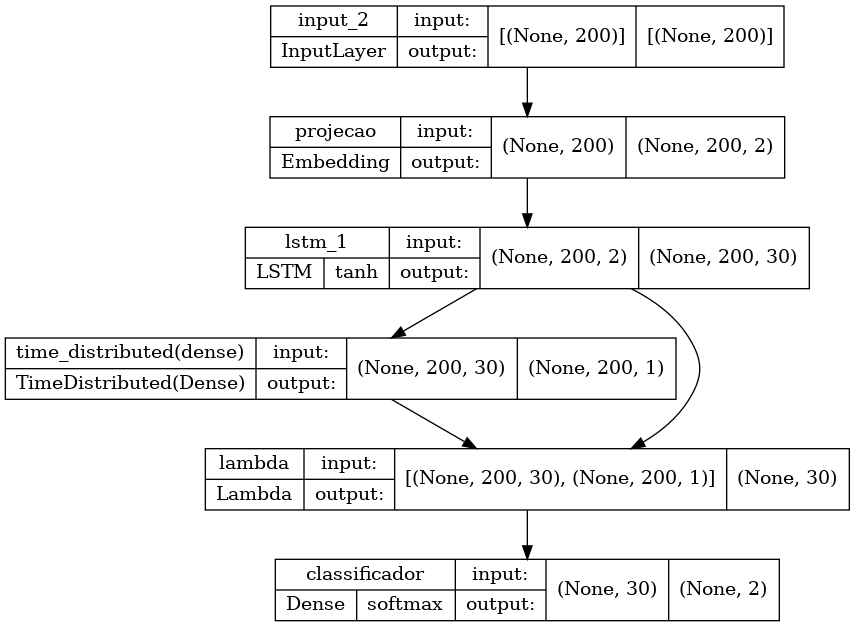

In [10]:
def rede_neural_com_atencao(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x = LSTM(30, return_sequences=True)(x)

  atencao = TimeDistributed(Dense(1, activation='sigmoid'))(x)
  contexto = Lambda(aplicar_atencao)( [x, atencao] )

  y = Dense(2, activation='softmax', name='classificador')(contexto)
  return Model(input_layer, y), Model(input_layer, atencao)

rede_neural, atencao = rede_neural_com_atencao(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=es)

Epoch 1/50
1000/1000 [==============================] - 21s 19ms/step - loss: 0.1346 - val_loss: 0.1091
Epoch 2/50
1000/1000 [==============================] - 22s 22ms/step - loss: 0.1043 - val_loss: 0.1027
Epoch 3/50
1000/1000 [==============================] - 31s 31ms/step - loss: 0.0987 - val_loss: 0.0987
Epoch 4/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.0971 - val_loss: 0.1011
Epoch 5/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.0943 - val_loss: 0.1056
Epoch 6/50
1000/1000 [==============================] - 29s 29ms/step - loss: 0.0946 - val_loss: 0.0966
Epoch 7/50
1000/1000 [==============================] - 28s 28ms/step - loss: 0.0928 - val_loss: 0.1030
Epoch 8/50
1000/1000 [==============================] - 30s 30ms/step - loss: 0.0920 - val_loss: 0.0963
Epoch 9/50
1000/1000 [==============================] - 31s 31ms/step - loss: 0.0915 - val_loss: 0.0971
Epoch 10/50
1000/1000 [==============================] - 30s 30m

In [12]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.87      0.88      0.88      5053
    positive       0.88      0.87      0.87      4947

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



# Exercício 5
*Objetivo: visualizar as saídas da camada de atenção*

Uma informação relevante de uma rede com atenção é o próprio sinal de atenção, pois ele nos informa quais foram as palavras que mais contribuíram para a classificação final.

1. Onde definimos a variável `atencao`? Quando a rede `atencao` foi treinada?
1. As palavras mais relevantes encontradas pela rede fazem sentido em relação ao problema?
1. As palavras mais relevantes são as mesmas em qualquer amostra de texto? Por que?

In [13]:
at = atencao.predict(X_test)
#print(X_test[0])
#print(at[0])
words = tokenizer.sequences_to_texts(X_test)

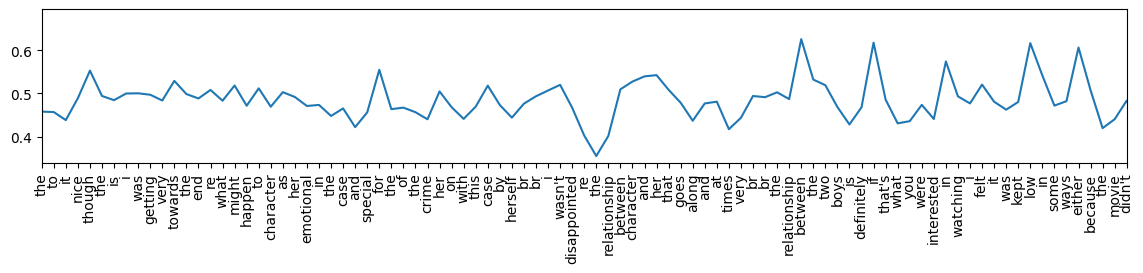

In [15]:
idx=15
plt.figure(figsize=(14,2))
n_words = len(words[idx].split())
at_ = at[idx,-n_words:]
plt.plot(at_)
plt.xticks(range(n_words), words[idx].split(), rotation=90)
plt.xlim([0,90])
plt.show()

In [16]:
len(words[10].split())
len(at[idx,:])

200

# Exercício 6
*Objetivo: usar uma rede de atenção com encoder bi-direcional*

Uma propriedade de textos é que, em algumas situações, o significado de palavras depende de palavras que estão mais adiante. Para modelar isso como uma sequência, uma possível solução é (literalmente) inverter o texto, e trabalhar com ele invertido. Nesse caso, precisamos combinar tanto o modelo que vai "para a frente" quanto o que vai "para trás".

No código abaixo:
1. Encontre a camada que lê o texto em sentido *direto*
1. Encontre a camada que lê o texto em sentido *reverso*
1. Encontre a camada que combina as duas informações

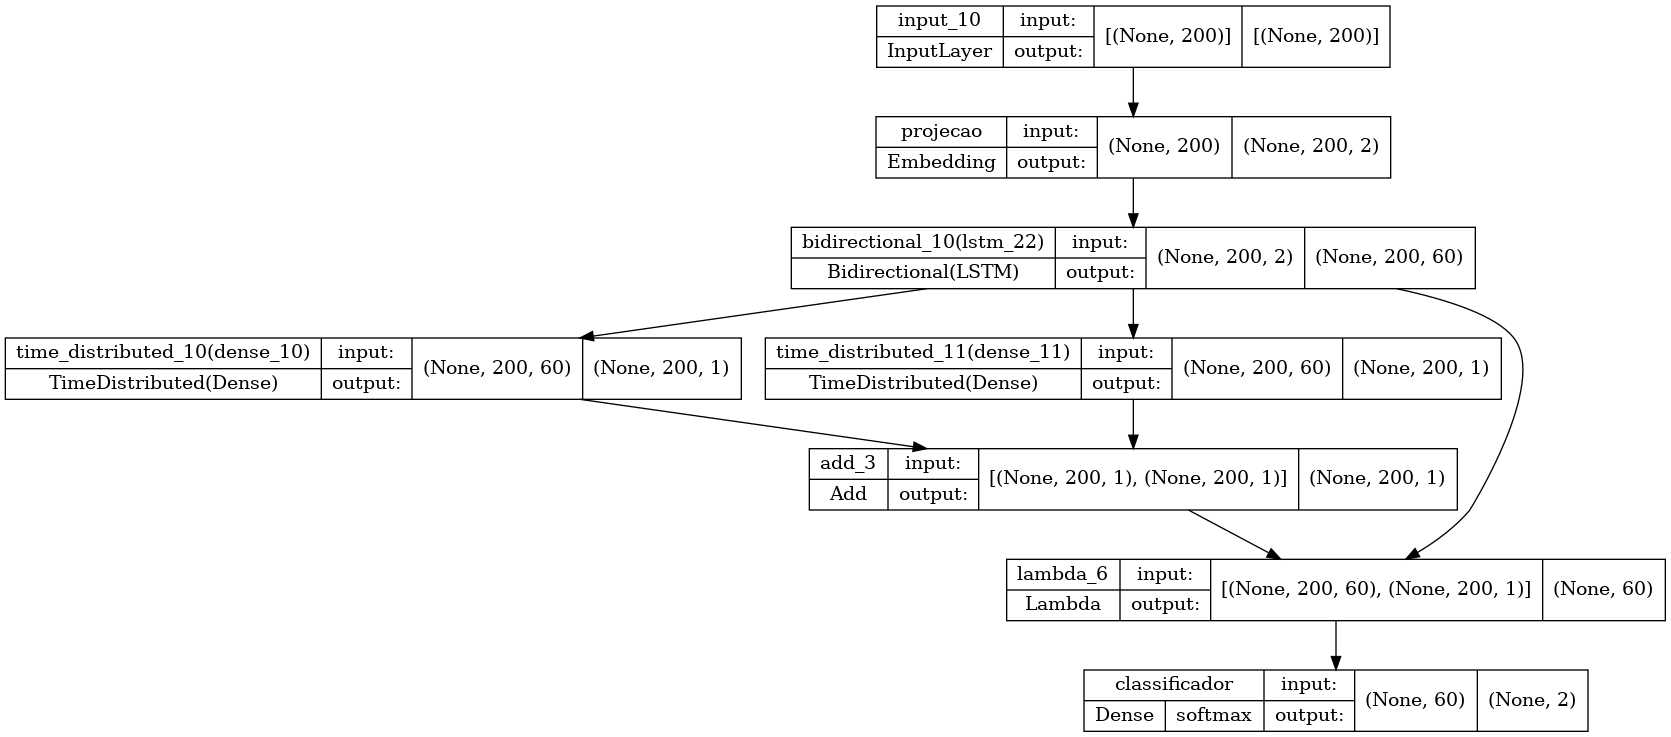

In [37]:
def aplicar_atencao(par):
  estados, atencao = par[0], par[1]
  atencao_aplicada = estados * atencao
  contexto = sum(atencao_aplicada, axis=1)
  return contexto

def rede_neural_com_atencao_bidirecional(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x_forward = LSTM(30, return_sequences=True)
  x_backward = LSTM(30, return_sequences=True, go_backwards=True)
  x = Bidirectional(x_forward, backward_layer=x_backward)(x)

  atencao1 = TimeDistributed(Dense(1, activation='sigmoid'))(x)
  atencao2 = TimeDistributed(Dense(1, activation='sigmoid'))(x)
  atencao = Add()([atencao1, atencao2])
  contexto = Lambda(aplicar_atencao)( [x, atencao] )

  y = Dense(2, activation='softmax', name='classificador')(contexto)
  return Model(input_layer, y), Model(input_layer, atencao1), Model(input_layer, atencao2)

rede_neural, atencao1, atencao2 = rede_neural_com_atencao_bidirecional(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=es)

Epoch 1/50
1000/1000 [==============================] - 27s 24ms/step - loss: 0.1397 - val_loss: 0.1250
Epoch 2/50
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1031 - val_loss: 0.1069
Epoch 3/50
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1013 - val_loss: 0.1008
Epoch 4/50
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0980 - val_loss: 0.1028
Epoch 5/50
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0958 - val_loss: 0.0975
Epoch 6/50
1000/1000 [==============================] - 26s 26ms/step - loss: 0.0951 - val_loss: 0.1015
Epoch 7/50
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0937 - val_loss: 0.0967
Epoch 8/50
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0919 - val_loss: 0.1078
Epoch 9/50
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0885 - val_loss: 0.0947
Epoch 10/50
 957/1000 [===========================>..] - ETA: 1s

# Exercício 7
*Objetivo: avaliar a rede neural com encoder bi-direcional*

Usando o código abaixo, avalie o desempenho e o sinal de atenção gerado pela nova rede neural.

Houve diferenças evidentes em relação ao caso anterior?

In [ ]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.88      0.88      0.88      5053
    positive       0.87      0.87      0.87      4947

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
at = atencao1.predict(X_test)
at2 = atencao2.predict(X_test)
#print(X_test[0])
#print(at[0])
words = tokenizer.sequences_to_texts(X_test)

In [ ]:
len(words[10].split())
len(at[idx,:])

200

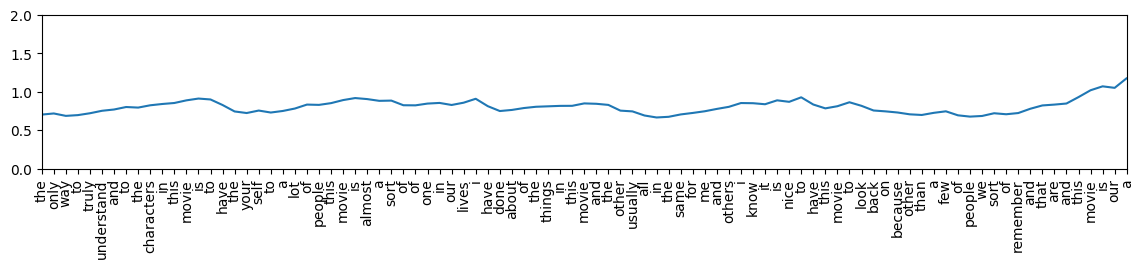

In [ ]:
idx=88
plt.figure(figsize=(14,2))
n_words = len(words[idx].split())
at_ = at[idx,-n_words:]
at2_ = at2[idx,-n_words:]
plt.plot(at_)
plt.plot(at2_)
plt.xticks(range(n_words), words[idx].split(), rotation=90)
plt.xlim([0,90])
plt.ylim([0,1])
plt.show()